In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import datetime
import os
import os.path
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [123]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#data_dir = 'div2k' #Just to check
data_dir = 'dataset_3_classes'
batch_size = 32
# Number of training epochs
num_epochs = 512
LOAD_MODEL = True
PATH='/content/drive/My Drive/augGAN/model/+3.610_+0.208_512_2020-08-07_12:05:28.dat' #Normal_512
#PATH='/content/drive/My Drive/augGAN/model/+4.966_+0.099_512_2020-08-07_14:54:02.dat' #Covid_512
TRAIN_ALL = False
#All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.002
lr_d = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
# Input to generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #batch of 64
# Define Loss function
criterion = nn.BCELoss()

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# class Generator(nn.Module):

#     def __init__(self):
#         super(Generator, self).__init__()
#         self._model = nn.Sequential(
#             # input is Z, going into a convolution
#             #i/p,o/p,kernel size,stride,padding
#             nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 16),
#             nn.ReLU(True),
#             # state size. (ngf*16) x 4 x 4
#             nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 8 x 8
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 16 x 16
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 32 x 32
#             nn.ConvTranspose2d( ngf*2, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         return self._model(input)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# class Discriminator(nn.Module):

#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self._model = nn.Sequential(
#             # input is (nc) x 64 x 64
#             nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 32 x 32
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 16 x 16
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 8 x 8
#             nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 16),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*16) x 4 x 4
#             nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self._model(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
def plot_loss(G_losses, D_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [9]:
def plot(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [11]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    name = "%+.3f_%+.3f_%d_%s.dat" % (g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S"))
    fname = os.path.join('.', 'augGAN/model', name)
    states = {
            'state_dict_generator': generator.state_dict(),
            'state_dict_discriminator': discriminator.state_dict(),
            'gen_optimizer': gen_optimizer.state_dict(),
            'dis_optimizer': dis_optimizer.state_dict(),
            'metrics': metrics,
            'train_epoch': num_epochs,
            'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    }
    torch.save(states, fname)
    path='augGAN/plots/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H:%M:%S"))
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    plot('G_losses', num_epochs, metrics['train.G_losses'], path, True)
    plot('D_losses', num_epochs, metrics['train.D_losses'], path, True)
    plot('D_x', num_epochs, metrics['train.D_x'], path, True)
    plot('D_G_z1', num_epochs, metrics['train.D_G_z1'], path, True)
    plot('D_G_z2', num_epochs, metrics['train.D_G_z2'], path, True)

In [105]:
# def display_real_fake(loader, img_list):
#     real_batch = next(iter(loader))

#     # Plot the real images
#     plt.figure(figsize=(15,15))
#     plt.subplot(1,2,1)
#     plt.axis("off")
#     plt.title("Real Images")
#     plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

#     # Plot the fake images from the last epoch
#     plt.subplot(1,2,2)
#     plt.axis("off")
#     plt.title("Fake Images")
#     plt.imshow(np.transpose(img_list[-1],(1,2,0)))
#     plt.show()

In [106]:
img_list = []
G_losses = []
D_losses = []

def train_gan(generator, discriminator, gen_optimizer, dis_optimizer, train_loader, num_epochs, metrics):
        iters = 0
        print("GAN training started :D...")

        for epoch in range(num_epochs):
            print("Epoch %d" %(epoch+1))
            # For each batch in the dataloader
            for i, data in enumerate(tqdm(train_loader, 0)):
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ## Train with all-real batch
                discriminator.zero_grad()
                # Format batch
                b_real = data[0].to(device)
                b_size = b_real.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = discriminator(b_real).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()
                metrics['train.D_x'].append(D_x)

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                # Generate fake image batch with G
                fake = generator(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = discriminator(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                metrics['train.D_G_z1'].append(D_G_z1)
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                dis_optimizer.step()
                # if i>0:
                #     if errD.item()>G_losses[i-1]:
                #         dis_optimizer.step()
                # else:
                #     dis_optimizer.step()

                # (2) Update G network: maximize log(D(G(z)))
                generator.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = discriminator(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                metrics['train.D_G_z2'].append(D_G_z2)
                # Update G
                gen_optimizer.step()

                # Output training stats
                #if i % 50 == 0:
                #print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                #      % (epoch, num_epochs, i, len(train_loader),
                #          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())
                metrics['train.G_losses'].append(errG.item())
                metrics['train.D_losses'].append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake = generator(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        #plot_loss(G_losses, D_losses)
        save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs)
        #display_real_fake(train_loader, img_list)

In [107]:
def get_indices(dataset, class_name, indices):
    #indices =  []
    j = 0
    #for i in range(len(dataset.labels)): #for stl10
    for i in range(len(dataset.targets)):
        #if dataset.labels[i] == class_name: #for stl10
        if dataset.targets[i] == class_name:
            indices.append(i)
            j += 1
    print("Total Samples of class", class_name,"found are",j)
    return indices

In [102]:
def test1(generator, discriminator, num_epochs, metrics):
    print('Testing Block.........')
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    path='augGAN/output_images'
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    test_img_list = []
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    test_fake = generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))
    fig = plt.figure(figsize=(15,15))
    fig = plt.axis("off")
    fig = plt.title("Fake Images")
    fig = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    get_fig = plt.gcf()
    fig = plt.show()
    get_fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                    (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [118]:
def test2(generator, discriminator, num_epochs, metrics, loader):
    print('Testing Block.........')
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    path='augGAN/output_images'
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    real_batch = next(iter(loader))
    
    test_img_list = []
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    test_fake = generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(15,15))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    #ax2 = plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                    (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [109]:
# def test_fake(generator, discriminator, metrics):
#     now = datetime.datetime.now()
#     g_losses = metrics['train.G_losses'][-1]
#     d_losses = metrics['train.D_losses'][-1]
#     path='augGAN/output_images/%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H:%M:%S"))
#     try:
#       os.mkdir(os.path.join('.', path))
#     except Exception as error:
#       print(error)

#     im_batch_size = 50
#     n_images=100
#     for i_batch in range(0, n_images, im_batch_size):
#         gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
#         gen_images = generator(gen_z)
#         dis_result = discriminator(gen_images).view(-1)
#         images = gen_images.to("cpu").clone().detach()
#         images = images.numpy().transpose(0, 2, 3, 1)
#         for i_image in range(gen_images.size(0)):
#             save_image(gen_images[i_image, :, :, :], os.path.join(path, f'image_{i_batch+i_image:05d}.png'))

#     print('Testing Block.........')
#     print('Discriminator_mean: ', dis_result.mean().item())
#     #import shutil
#     #shutil.make_archive('images', 'zip', './augGAN/output_images')

[Errno 17] File exists: './augGAN'
[Errno 17] File exists: './augGAN/model'
[Errno 17] File exists: './augGAN/plots'
[Errno 17] File exists: './augGAN/output_images'
GAN loaded for epochs:  512
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentu

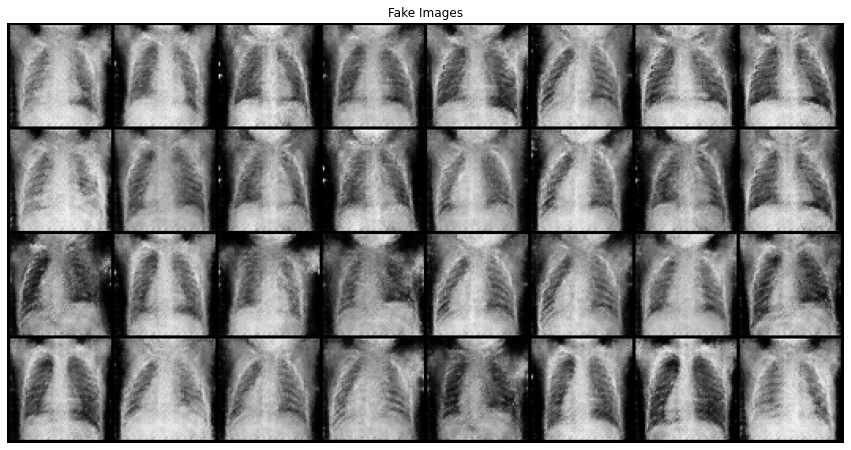

In [124]:
for func in [
    lambda: os.mkdir(os.path.join('.', 'augGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/model')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/plots')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/output_images'))]:  # create directories
  try:
    func()
  except Exception as error:
    print(error)
    continue

METRIC_FIELDS = [
    'train.D_x',
    'train.D_G_z1',
    'train.D_G_z2',
    'train.G_losses',
    'train.D_losses',
]
metrics = {field: list() for field in METRIC_FIELDS}

if nc==1:
    mu = (0.5)
    sigma = (0.5)
    transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((64,64)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
elif nc==3:
    mu = (0.5,0.5,0.5)
    sigma = (0.5,0.5,0.5)
    #Originally authors used just scaling
    transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.Resize((64,64)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
else:
    print("Tranformation not defined for this option")
train_set = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform=transform)
#train_set = datasets.STL10(root='./data', split='train', download=True,
#                                transform=transform)
#train_loader = torch.utils.data.DataLoader(
#      train_set, batch_size=batch_size, shuffle=True)
#valid_set = datasets.ImageFolder(os.path.join( 
#      data_dir, "val/"), transform=transform)
#valid_set = datasets.STL10(root='./data', split='test', download=True,
#                                transform=transform)
#valid_loader = torch.utils.data.DataLoader(
#      valid_set, batch_size=batch_size, shuffle=False)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

if LOAD_MODEL:
    if torch.cuda.is_available():
      checkpoint = torch.load(PATH)
    else:
      checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
              
    generator.load_state_dict(checkpoint['state_dict_generator'])
    discriminator.load_state_dict(checkpoint['state_dict_discriminator'])
    gen_optimizer.load_state_dict(checkpoint['gen_optimizer'])
    dis_optimizer.load_state_dict(checkpoint['dis_optimizer'])
    metrics=checkpoint['metrics']
    num_epochs=checkpoint['train_epoch']
    date=checkpoint['date']
    generator.train(mode=False)
    discriminator.train(mode=False)
    print('GAN loaded for epochs: ', num_epochs)
    print(generator)
    print(discriminator)
    print(gen_optimizer)
    print(dis_optimizer)
    print(date)
    test1(generator, discriminator, num_epochs, metrics)
else:
    if TRAIN_ALL:
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                  shuffle=True)
        train_gan(generator, discriminator, gen_optimizer, dis_optimizer, train_loader,
                  num_epochs, metrics)
        test2(generator, discriminator, num_epochs, metrics, train_loader)
    else:
        idx = []
        idx = get_indices(train_set, 0, idx) #Airplane for stl10; covid for x-ray dataset
        #idx_2 = get_indices(train_set, 8, idx) #Ship
        #idx_3 = get_indices(train_set, 9, idx) #Truck

        print("Total samples now are ",len(idx))
        selected_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      sampler = SubsetRandomSampler(idx))
        train_gan(generator, discriminator, gen_optimizer, dis_optimizer, selected_loader,
                  num_epochs, metrics)
        test2(generator, discriminator, num_epochs, metrics, selected_loader)

In [44]:
path, dirs, files = next(os.walk(os.path.join(data_dir, "train/pneumonia_bac")))
print(len(files))

79


In [ ]:
from torchsummary import summary

summary(generator, (100, 1, 1))
summary(discriminator, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,

In [ ]:
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
